# Technical: conv-piVAE

- this notebook will demo conv-piVAE on hippocampus data, implemented based on piVAE (Zhou, D., Wei, X. Learning identifiable and interpretable latent models of high-dimensional neural activity using pi-VAE. NeurIPS 2020. https://arxiv.org/abs/2011.04798)

- This has only been tested on Ubuntu and MacOS

- Install note: be sure you have cebra, and the demo dependencies, installed to use this notebook: 

In [ ]:
!pip install 'cebra[datasets,demos]'

In [4]:
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import joblib as jl
from keras.callbacks import ModelCheckpoint
from keras import backend as K

sys.path.insert(0, '..')
import cebra.datasets

sys.path.insert(0, '../third_party/pivae')
import pivae_code.datasets, pivae_code.conv_pi_vae, pivae_code.pi_vae

In [5]:
###Set your own seed
seed = 42
np.random.seed(seed)

- Be sure you have downloaded the data and placed `/data` from [FigShare](https://figshare.com/s/60adb075234c2cc51fa3) and into the `demo_notebooks` directory. Let's check if it's there:

In [1]:
ls

Demo_Allen.ipynb                      Demo_learnable_temperature.ipynb
Demo_cohomology.ipynb                 Demo_primate_reaching.ipynb
Demo_consistency.ipynb                Demo_primate_reaching_mse_loss.ipynb
Demo_conv-pivae.ipynb                 Demo_synthetic_exp.ipynb
Demo_decoding.ipynb                   README.rst
Demo_hippocampus.ipynb                data/
Demo_hippocampus_multisession.ipynb   rat_demo_example_output.h5
Demo_hypothesis_testing.ipynb


## Load and generate dataset:

In [9]:
DATA_NAME = 'rat-hippocampus-achilles-3fold-trial-split-0'
offset_right = 5
offset_left = 5

def _call_dataset(offset_right, offset_left, split):
    dataset = cebra.datasets.init(DATA_NAME, split = split)
    dataset.offset.right = offset_right
    dataset.offset.left = offset_left
    return dataset

train_set = _call_dataset(offset_right, offset_left, 'train')
valid_set=_call_dataset(offset_right, offset_left, 'valid')
test_set=_call_dataset(offset_right, offset_left, 'test')

In [10]:
def make_loader(dataset, batch_size):
    def _to_batch_list(x, y, batch_size):
        if x is not None and y is not None:
            x = x.squeeze()
            if len(x.shape) == 3:
                x = x.transpose(0,2,1) 
            x_batch_list = np.array_split(x, int(len(x) / batch_size))
            y_batch_list = np.array_split(y, int(len(y) / batch_size))
        else:
            return None, None
        return x_batch_list, y_batch_list
    
    x,u = _to_batch_list(dataset[torch.arange(len(dataset))].numpy(), dataset.index.numpy(), batch_size)
    
    loader = pivae_code.pi_vae.custom_data_generator(x, u)
    _len = len(x)
    return x, u, loader

In [11]:
batch_size = 200
train_x, train_u, train_loader = make_loader(train_set, batch_size)
valid_x, valid_u, valid_loader = make_loader(valid_set, batch_size)
test_x, test_u, test_loader = make_loader(test_set, batch_size)

## Visualize the data

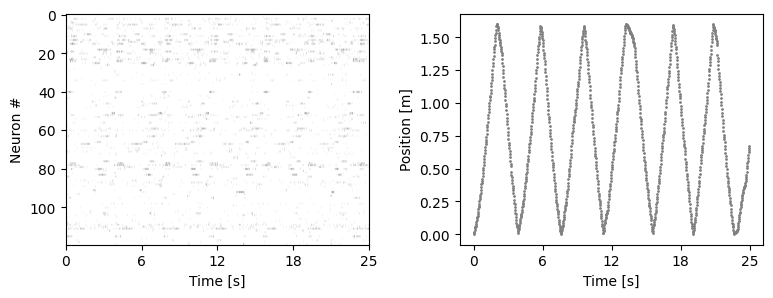

In [12]:
fig = plt.figure(figsize=(9,3))
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(train_set.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), train_set.continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

## Define and train a conv-piVAE model
- Note that conv-piVAE use 10 time bins (250ms) receptive field, while piVAE uses 1 time bin (25ms). 
- If training takes too long, use smaller training epochs (usually the loss converges around ~300 epochs)

In [13]:
conv_pivae = pivae_code.conv_pi_vae.conv_vae_mdl(
                dim_x=train_set.neural.shape[1],
                dim_z=2,
                dim_u=3,
                time_window=10,
                gen_nodes=60,
                n_blk=2,
                mdl="poisson",
                disc=False,
                learning_rate=0.00025)

2022-10-03 14:33:40.035925: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-03 14:33:40.035974: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-03 14:33:40.036015: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (stes-t14s): /proc/driver/nvidia/version does not exist
2022-10-03 14:33:40.036392: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-10-03 14:33:40.051370: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1697430000 Hz
2022-10-03 14:33:40.053336: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd814000b70 initialized for platform Host (this does not guarantee that 

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 120)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 35020       input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 10, 120)      2977794     encoder[1][2]                  

/home/stes/.conda/envs/cebra-full/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output encoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to encoder.
  warnings.warn(
/home/stes/.conda/envs/cebra-full/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  warnings.warn(


In [14]:
model_chk_path = 'conv_pivae_model0210.h5'
mcp = ModelCheckpoint(model_chk_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
s_n = conv_pivae.fit_generator(train_loader,
              steps_per_epoch=len(train_x), epochs=600, 
              verbose=1,
              validation_data = valid_loader,
              validation_steps = len(valid_x), callbacks=[mcp])

Epoch 1/600
34/34 [==============================] - 3s 100ms/step - loss: 509.8190 - val_loss: 212.0420
Epoch 2/600
34/34 [==============================] - 2s 46ms/step - loss: 212.5554 - val_loss: 177.2430
Epoch 3/600
34/34 [==============================] - 2s 45ms/step - loss: 192.3327 - val_loss: 165.8879
Epoch 4/600
34/34 [==============================] - 1s 42ms/step - loss: 186.7391 - val_loss: 164.7504
Epoch 5/600
34/34 [==============================] - 1s 43ms/step - loss: 186.4515 - val_loss: 164.5008
Epoch 6/600
34/34 [==============================] - 1s 43ms/step - loss: 186.4154 - val_loss: 164.6330
Epoch 7/600
34/34 [==============================] - 1s 43ms/step - loss: 186.4084 - val_loss: 164.6232
Epoch 8/600
34/34 [==============================] - 1s 44ms/step - loss: 186.3944 - val_loss: 164.5316
Epoch 9/600
34/34 [==============================] - 2s 46ms/step - loss: 186.2701 - val_loss: 164.2339
Epoch 10/600
34/34 [==============================] - 2s 46ms/s

34/34 [==============================] - 2s 48ms/step - loss: 149.7775 - val_loss: 133.0508
Epoch 80/600
34/34 [==============================] - 2s 44ms/step - loss: 149.6358 - val_loss: 132.8242
Epoch 81/600
34/34 [==============================] - 1s 43ms/step - loss: 149.8333 - val_loss: 132.9957
Epoch 82/600
34/34 [==============================] - 1s 43ms/step - loss: 149.6818 - val_loss: 134.0401
Epoch 83/600
34/34 [==============================] - 1s 43ms/step - loss: 150.2907 - val_loss: 133.8262
Epoch 84/600
34/34 [==============================] - 1s 43ms/step - loss: 150.5345 - val_loss: 134.5123
Epoch 85/600
34/34 [==============================] - 1s 44ms/step - loss: 150.5716 - val_loss: 134.5144
Epoch 86/600
34/34 [==============================] - 1s 43ms/step - loss: 150.1075 - val_loss: 134.8088
Epoch 87/600
34/34 [==============================] - 1s 44ms/step - loss: 149.7634 - val_loss: 134.5372
Epoch 88/600
34/34 [==============================] - 1s 44ms/step -

34/34 [==============================] - 1s 42ms/step - loss: 142.3853 - val_loss: 134.1011
Epoch 234/600
34/34 [==============================] - 2s 44ms/step - loss: 142.3228 - val_loss: 134.8532
Epoch 235/600
34/34 [==============================] - 1s 44ms/step - loss: 142.2588 - val_loss: 134.8331
Epoch 236/600
34/34 [==============================] - 1s 43ms/step - loss: 142.6255 - val_loss: 134.5482
Epoch 237/600
34/34 [==============================] - 1s 43ms/step - loss: 142.5364 - val_loss: 134.9104
Epoch 238/600
34/34 [==============================] - 2s 44ms/step - loss: 142.6134 - val_loss: 134.7059
Epoch 239/600
34/34 [==============================] - 2s 47ms/step - loss: 142.6284 - val_loss: 134.9820
Epoch 240/600
34/34 [==============================] - 2s 48ms/step - loss: 142.7501 - val_loss: 135.5601
Epoch 241/600
34/34 [==============================] - 2s 50ms/step - loss: 142.8515 - val_loss: 135.3673
Epoch 242/600
34/34 [==============================] - 2s 47

34/34 [==============================] - 2s 45ms/step - loss: 137.3657 - val_loss: 142.2761
Epoch 388/600
34/34 [==============================] - 2s 45ms/step - loss: 137.2203 - val_loss: 140.8026
Epoch 389/600
34/34 [==============================] - 2s 45ms/step - loss: 137.1903 - val_loss: 141.0476
Epoch 390/600
34/34 [==============================] - 2s 48ms/step - loss: 137.0710 - val_loss: 140.7649
Epoch 391/600
34/34 [==============================] - 2s 45ms/step - loss: 137.1322 - val_loss: 141.4252
Epoch 392/600
34/34 [==============================] - 2s 45ms/step - loss: 137.4431 - val_loss: 141.5249
Epoch 393/600
34/34 [==============================] - 2s 45ms/step - loss: 137.3807 - val_loss: 141.4614
Epoch 394/600
34/34 [==============================] - 2s 46ms/step - loss: 137.9727 - val_loss: 141.5533
Epoch 395/600
34/34 [==============================] - 2s 45ms/step - loss: 137.7742 - val_loss: 142.6848
Epoch 396/600
34/34 [==============================] - 2s 45

34/34 [==============================] - 2s 46ms/step - loss: 133.5697 - val_loss: 149.5192
Epoch 542/600
34/34 [==============================] - 2s 46ms/step - loss: 133.4706 - val_loss: 148.3766
Epoch 543/600
34/34 [==============================] - 2s 46ms/step - loss: 133.8055 - val_loss: 148.3919
Epoch 544/600
34/34 [==============================] - 2s 45ms/step - loss: 133.7280 - val_loss: 147.1725
Epoch 545/600
34/34 [==============================] - 2s 46ms/step - loss: 133.6027 - val_loss: 147.6811
Epoch 546/600
34/34 [==============================] - 2s 46ms/step - loss: 133.4496 - val_loss: 147.0526
Epoch 547/600
34/34 [==============================] - 2s 46ms/step - loss: 133.6999 - val_loss: 146.1245
Epoch 548/600
34/34 [==============================] - 2s 46ms/step - loss: 133.6330 - val_loss: 146.5956
Epoch 549/600
34/34 [==============================] - 2s 45ms/step - loss: 133.3718 - val_loss: 147.9286
Epoch 550/600
34/34 [==============================] - 2s 46

In [15]:
conv_pivae.load_weights(model_chk_path)

In [16]:
outputs = conv_pivae.predict([np.concatenate(train_x),
                            np.concatenate(train_u)])
# Outputs: post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var
post_z = outputs[0]
mean_z = outputs[6]
labels = np.concatenate(train_u)

## Visualize the embedding

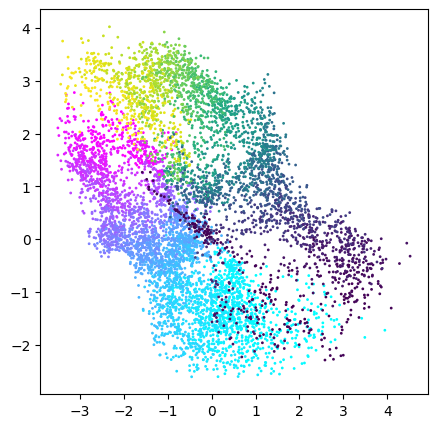

In [17]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
r_ind = labels[:,1] == 1
l_ind = labels[:,2] == 1
ax.scatter(post_z[r_ind, 0], post_z[r_ind, 1], c=labels[r_ind,0], s=1, cmap = 'cool')
ax.scatter(post_z[l_ind, 0], post_z[l_ind, 1], c=labels[l_ind,0], s=1, cmap = 'viridis')


## Decoding the position using Monte Carlo sampling

- This method takes a while since it uses random sampling from p(z|u) to approximate p(u|x). 
- Below functions to compute marginal likelihood and decode are copied and adapted from the pi-VAE repo  https://github.com/zhd96/pi-vae/blob/main/code/util.py, https://github.com/zhd96/pi-vae/blob/main/examples/pi-vae_rat_data.ipynb

In [18]:
def compute_marginal_lik_poisson(vae_mdl,
                                 x_test,
                                 u_fake,
                                 n_sample,
                                 log_opt=False):
    lik_all = []

    for jj in range(len(x_test)):  ## for each batch
        lik_test = []
        for ii in range(len(u_fake)):  ## for each unique u value
            opts = vae_mdl.predict([x_test[jj], u_fake[ii][jj]])
            lam_mean = opts[4]
            lam_log_var = opts[5]
            z_dim = lam_mean.shape
            z_sample = np.random.normal(0,
                                        1,
                                        size=(n_sample, z_dim[0], z_dim[1]))
            z_sample = z_sample * np.exp(0.5 * lam_log_var) + lam_mean

            ## compute fire rate ##
            get_fire_rate_output = K.function(
                [vae_mdl.layers[-1].get_input_at(0)],
                [vae_mdl.layers[-1].get_output_at(0)],
            )
            fire_rate = get_fire_rate_output([z_sample.reshape(-1,
                                                               z_dim[-1])])[0]
            fire_rate = fire_rate.reshape(n_sample, -1, fire_rate.shape[-2],
                                          fire_rate.shape[-1])
            ## compute p(x|z) poisson likelihood ##
            loglik = x_test[jj] * np.log(np.clip(fire_rate, 1e-10,
                                                 1e7)) - fire_rate
            # n_sample*n_time*n_neuron
            loglik = loglik.sum(axis=(-2, -1), dtype = np.float64)
            ## sum across neurons and time
            loglik_max = loglik.max(axis=0)
            loglik -= loglik_max
            if log_opt:
                tmp = np.log(np.exp(loglik).mean(axis=0)) + (loglik_max)
            else:
                tmp = (np.exp(loglik).mean(axis=0)) * np.exp(loglik_max)
            lik_test.append(tmp)
        lik_all.append(np.array(lik_test))

    return lik_all


def decode_sampling_rat(test_x, test_y, model, sampling_num):
    hd_bins = np.linspace(0, 1.6, 100)
    hd_bins_dir = np.hstack([np.concatenate([np.linspace(0,1.6,100), np.linspace(0,1.6,100)])[...,None], np.zeros((200,2))]) 
    hd_bins_dir[:100][:,1]=1
    hd_bins_dir[100:200][:,2]=1
    nu_sample = 200
    u_fake = []
    for jj in range(nu_sample):
        tmp_all = []
        for ii in range(len(test_x)):
            nn = test_x[ii].shape[0]
            tmp = np.hstack((np.ones((nn, 1)) * hd_bins[jj % 100], np.zeros((nn, 2))))
            if jj >= (nu_sample // 2):
                tmp[:, 2] += 1
            else:
                tmp[:, 1] += 1
            tmp_all.append(tmp)
        u_fake.append(np.array(tmp_all))
    u_fake = np.array(u_fake)

    ## compute loglik

    lik_all = compute_marginal_lik_poisson(model, test_x, u_fake, sampling_num)
    decode_use = np.array(
        [
            (lik_all[jj]).reshape(200, -1, order="F").argmax(axis=0)
            for jj in range(len(lik_all))
        ]
    )
    median_err = np.median(
        np.abs(
            [
                hd_bins_dir[np.concatenate(decode_use)[i],0] - np.concatenate(test_y)[i, 0]
                for i in range(len(np.concatenate(test_y)))
            ]
        )
    )

    prediction = [
        hd_bins_dir[np.concatenate(decode_use)[i]]
        for i in range(len(np.concatenate(test_y)))
    ]

    return median_err, prediction

In [19]:
## Set smaller sampling_num to reduce computing time
median_err, prediction = decode_sampling_rat(test_x, test_u, conv_pivae, sampling_num=100)


/tmp/ipykernel_165463/761218901.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  u_fake.append(np.array(tmp_all))
/tmp/ipykernel_165463/761218901.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  decode_use = np.array(


In [20]:
print(f'Median Err [m]: {median_err}')

Median Err [m]: 0.09438572947425072


## Decoding with the embedding using kNN

- Here we test kNN decoding on piVAE embedding without label prior, the same method we use for decoding with CERBA embeddings.

In [21]:
train_outputs = conv_pivae.predict([np.concatenate(train_x),
                            np.concatenate(train_u)])
valid_outputs = conv_pivae.predict([np.concatenate(valid_x),
                            np.concatenate(valid_u)])
test_outputs = conv_pivae.predict([np.concatenate(test_x),
                            np.concatenate(test_u)])

train_post_z = train_outputs[6]
valid_post_z = valid_outputs[6]
test_post_z = test_outputs[6]

In [22]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import sklearn.metrics

def decoding_pos_dir(emb_train, emb_valid, emb_test, label_train, label_valid, label_test):
    metric = 'cosine'
    neighbors = np.power(np.arange(1,6, dtype = int),2)
    valid_scores = []
    for n in neighbors:
        pos_decoder = KNeighborsRegressor(n, metric = metric)
        dir_decoder = KNeighborsClassifier(n, metric = metric)
        pos_decoder.fit(emb_train, label_train[:,0])
        dir_decoder.fit(emb_train, label_train[:,1])
        pos_pred = pos_decoder.predict(emb_valid)
        dir_pred = dir_decoder.predict(emb_valid)
        prediction =np.stack([pos_pred, dir_pred],axis = 1)
        valid_score = sklearn.metrics.r2_score(label_valid[:,:2], prediction)
        valid_scores.append(valid_score)
    
    best_n=neighbors[np.argmax(valid_scores)]
    
    pos_decoder = KNeighborsRegressor(best_n, metric = metric)
    dir_decoder = KNeighborsClassifier(n, metric = metric)
    pos_decoder.fit(emb_train, label_train[:,0])
    dir_decoder.fit(emb_train, label_train[:,1])
    pos_pred = pos_decoder.predict(emb_test)
    dir_pred = dir_decoder.predict(emb_test)
    prediction =np.stack([pos_pred, dir_pred],axis = 1)
    pos_test_err = np.median(abs(prediction[:,0] - label_test[:, 0]))
    
    return pos_test_err

train_label = np.concatenate(train_u)
valid_label = np.concatenate(valid_u)
test_label = np.concatenate(test_u)
pos_test_err = decoding_pos_dir(train_post_z, valid_post_z, test_post_z, train_label, valid_label, test_label )

In [23]:
print(f'Median Err: {pos_test_err} m')

Median Err: 0.10224993526935577 m
